In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('./data/hw2_data.txt', sep='\t')

In [148]:
# #Dump all environment variables
#import dill
#dill.dump_session('notebook_env.db')

In [3]:
#Import all environment variables
import dill
dill.load_session('notebook_env.db')

In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.neighbors import KNeighborsRegressor

data = pd.read_csv('./data/hw2_data.txt', sep='\t')
X, y = data.iloc[:,4:].to_numpy(), data.iloc[:,0].to_numpy()

test_size = 0.2

In [6]:
#Error measures

def MSE(true, pred):
    MSE = np.mean((true-np.round(pred))**2)
    return MSE

def MAE(true, pred):
    MAE = np.mean(np.abs(true-np.round(pred)))
    return MAE

# Question 2 (K=5), fixed K

In [7]:
n_neighbors = 5

## Holdout

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=test_size,
                                                   random_state=1)
V = np.cov(X_train.T)

KNN_regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                     weights='uniform',
                                     algorithm='auto',
                                     metric='mahalanobis',
                                     metric_params={'V':V})

KNN_regressor.fit(X_train, y_train)
pred = KNN_regressor.predict(X_test)

print(f" Holdout \n MSE: {MSE(y_test, pred):.4f}\n MAE: {MAE(y_test, pred):.4f}" )

# %store X_train
# %store X_test
# %store y_train
# %store y_test

 Holdout 
 MSE: 338.2290
 MAE: 15.6902


## Repeated holdout

In [9]:
def repeated_holdout(X, y, n, test_size, n_neighbors, seed=12345, log=True):

    rng = np.random.RandomState(seed=seed)
    seeds = np.arange(10**5); rng.shuffle(seeds)
    seeds=seeds[:n]

    metrics, means, std = [np.empty((n,4)) for _ in range(3)]

    for index, seed in enumerate(seeds):
        X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=test_size,
                                                       random_state=seed)
        V = np.cov(X_train.T)

        KNN_regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                             weights='uniform',
                                             algorithm='auto',
                                             metric='mahalanobis',
                                             metric_params={'V':V})

        KNN_regressor.fit(X_train, y_train)
        pred_test = KNN_regressor.predict(X_test)
        pred_train = KNN_regressor.predict(X_train)
        metrics[index,:] = MSE(y_test, pred_test), MAE(y_test, pred_test), MSE(y_train, pred_train), MAE(y_train, pred_train)
        means[index,:] = np.mean(metrics[:(index+1)], axis=0)
        std[index,:] = np.std(metrics[:(index+1)], axis=0)
        
        if ((index+1) % (int(n/10)) == 0) & log:
            print(f"{index+1} / {n} test MSE: {metrics[index,:][0]:.4f} std: {std[index,:][0]:.4f} | train MSE: {metrics[index,:][2]:.4f} std: {std[index,:][2]:.4f}")
    if log:
        print("Done!")
    
    return metrics, means, std

In [10]:
def plot_train_test(train_mean, train_std, test_mean, test_std, length, markevery, xlab, ylab, lim, file, std=True):

    number_of_repetitions = np.arange(length)

    plt.plot(number_of_repetitions, train_mean,
             color='blue', marker='o',
             markersize=5, label=f'training {ylab}', markevery=markevery)

    plt.plot(number_of_repetitions, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label=f'test {ylab}', markevery=markevery)

    if std:
        plt.fill_between(number_of_repetitions,
                         test_mean + test_std,
                         test_mean - test_std,
                         alpha=0.15, color='green')

        plt.fill_between(number_of_repetitions,
                         train_mean + train_std,
                         train_mean - train_std,
                         alpha=0.15, color='blue')

    plt.grid()
    plt.xlabel(f'{xlab}')
    plt.ylabel(f'{ylab}')
    plt.legend(loc='lower right')
    plt.ylim(lim)
    plt.tight_layout()
    plt.savefig(f'images/{file}.svg', dpi=300)
    plt.show()

In [11]:
n = 100

metrics_rh, means_rh, std_rh = repeated_holdout(X, y, n, test_size, n_neighbors)

10 / 100 test MSE: 345.0303 std: 27.7801 | train MSE: 243.7462 std: 7.7128
20 / 100 test MSE: 384.8182 std: 26.2690 | train MSE: 232.6400 std: 7.3160
30 / 100 test MSE: 352.9529 std: 23.5281 | train MSE: 238.1737 std: 6.4456
40 / 100 test MSE: 365.3973 std: 22.6153 | train MSE: 229.6788 std: 6.1511
50 / 100 test MSE: 379.4209 std: 21.7601 | train MSE: 228.3685 std: 5.8853
60 / 100 test MSE: 341.6902 std: 21.8556 | train MSE: 236.8879 std: 5.8212
70 / 100 test MSE: 374.5084 std: 22.3327 | train MSE: 232.4840 std: 5.7130
80 / 100 test MSE: 356.7980 std: 21.7454 | train MSE: 228.5261 std: 5.5356
90 / 100 test MSE: 307.6296 std: 21.6647 | train MSE: 241.7960 std: 5.4856
100 / 100 test MSE: 361.6869 std: 21.1714 | train MSE: 231.9890 std: 5.4370
Done!


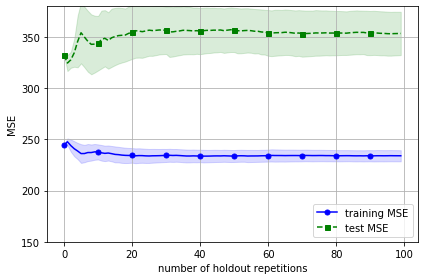

In [12]:
train_mean = means_rh[:,2]
train_std = std_rh[:,2]
test_mean = means_rh[:,0]
test_std = std_rh[:,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=n,
                markevery=10,
                xlab='number of holdout repetitions',
                ylab='MSE',
                lim=[150, 380],
                file='MSE_holdout100')

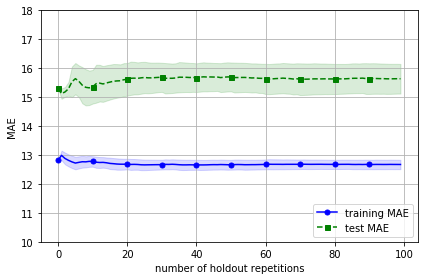

In [13]:
train_mean = means_rh[:,3]
train_std = std_rh[:,3]
test_mean = means_rh[:,1]
test_std = std_rh[:,1]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=n,
                markevery=10,
                xlab='number of holdout repetitions',
                ylab='MAE',
                lim=[10, 18],
                file='MAE_holdout100')

## Leave-One-Out Cross-Validation (LOOCV)

In [14]:
def loocv(X, y, n_neighbors, log=True, seed=1):
        
    n = X.shape[0]

    metrics, means, std = [np.empty((n,4)) for _ in range(3)]

    cv = KFold(n_splits=n, shuffle=True, random_state=seed)

    for index, (train_index, test_index) in enumerate(cv.split(X, y)):

        V = np.cov(X[train_index].T)

        KNN_regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                             weights='uniform',
                                             algorithm='auto',
                                             metric='mahalanobis',
                                             metric_params={'V':V})

        KNN_regressor.fit(X[train_index], y[train_index])

        pred_test = KNN_regressor.predict(X[test_index])
        pred_train = KNN_regressor.predict(X[train_index])
        metrics[index,:] = MSE(y[test_index], pred_test), MAE(y[test_index], pred_test), MSE(y[train_index], pred_train), MAE(y[train_index], pred_train)
        means[index,:] = np.mean(metrics[:(index+1)], axis=0)
        std[index,:] = np.std(metrics[:(index+1)], axis=0)
        
        if ((index+1) % (int(n/10)) == 0) & log:
           print(f"{index+1} / {n} test MSE: {metrics[index,:][0]:.4f} std: {std[index,:][0]:.4f} | train MSE: {metrics[index,:][2]:.4f} std: {std[index,:][2]:.4f}")
    if log:
        print("Done!")
    
    return metrics, means, std

In [15]:
metrics_loocv, means_loocv, std_loocv = loocv(X, y, n_neighbors) 

148 / 1483 test MSE: 196.0000 std: 331.6123 | train MSE: 233.8279 std: 0.3839
296 / 1483 test MSE: 25.0000 std: 331.4839 | train MSE: 233.0803 std: 0.3811
444 / 1483 test MSE: 64.0000 std: 354.2768 | train MSE: 232.3320 std: 0.3912
592 / 1483 test MSE: 529.0000 std: 365.5174 | train MSE: 233.2213 std: 0.4085
740 / 1483 test MSE: 324.0000 std: 365.7593 | train MSE: 233.5850 std: 0.4091
888 / 1483 test MSE: 16.0000 std: 386.1413 | train MSE: 233.6242 std: 0.4082
1036 / 1483 test MSE: 169.0000 std: 392.5298 | train MSE: 233.2429 std: 0.4095
1184 / 1483 test MSE: 784.0000 std: 399.4872 | train MSE: 233.8327 std: 0.4143
1332 / 1483 test MSE: 324.0000 std: 391.1226 | train MSE: 233.6316 std: 0.4085
1480 / 1483 test MSE: 81.0000 std: 401.0179 | train MSE: 233.8792 std: 0.4104
Done!


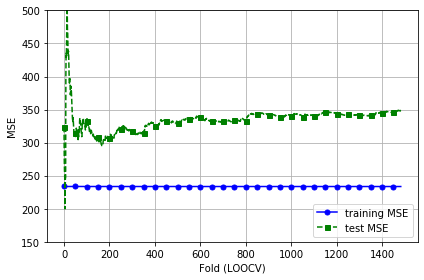

In [16]:
train_mean = means_loocv[:,2]
train_std = std_loocv[:,2]
test_mean = means_loocv[:,0]
test_std = std_loocv[:,0]

n = X.shape[0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=n,
                markevery=50,
                xlab='Fold (LOOCV)',
                ylab='MSE',
                lim=[150, 500],
                file='MSE_holdoutLOOCV',
                std=False)

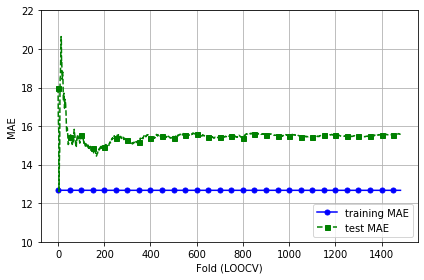

In [17]:
train_mean = means_loocv[:,3]
train_std = std_loocv[:,3]
test_mean = means_loocv[:,1]
test_std = std_loocv[:,1]

n = X.shape[0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=n,
                markevery=50,
                xlab='Fold (LOOCV)',
                ylab='MAE',
                lim=[10, 22],
                file='MAE_holdoutLOOCV',
                std=False)

## 10-fold Cross-Validation (CV)

In [18]:
def k_fold_cv(X, y, n_neighbors, folds, seed=1, log=True):

    n = folds

    metrics, means, std = [np.empty((folds,4)) for _ in range(3)]

    cv = KFold(n_splits=folds, shuffle=True, random_state=seed)

    for index, (train_index, test_index) in enumerate(cv.split(X, y)):

        V = np.cov(X[train_index].T)

        KNN_regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                             weights='uniform',
                                             algorithm='auto',
                                             metric='mahalanobis',
                                             metric_params={'V':V})

        KNN_regressor.fit(X[train_index], y[train_index])

        pred_test = KNN_regressor.predict(X[test_index])
        pred_train = KNN_regressor.predict(X[train_index])
        metrics[index,:] = MSE(y[test_index], pred_test), MAE(y[test_index], pred_test), MSE(y[train_index], pred_train), MAE(y[train_index], pred_train)
        means[index,:] = np.mean(metrics[:(index+1)], axis=0)
        std[index,:] = np.std(metrics[:(index+1)], axis=0)
        
        if ((index+1) % (int(n/10)) == 0) & log:
            print(f"{index+1} / {n} test MSE: {metrics[index,:][0]:.4f} std: {std[index,:][0]:.4f} | train MSE: {metrics[index,:][2]:.4f} std: {std[index,:][2]:.4f}")
    if log:
        print("Done!")
    
    return metrics, means, std

In [19]:
folds = 10

metrics_cv, means_cv, std_cv = k_fold_cv(X, y, n_neighbors, folds)

1 / 10 test MSE: 333.8188 std: 0.0000 | train MSE: 234.4640 std: 0.0000
2 / 10 test MSE: 345.0268 std: 5.6040 | train MSE: 235.7346 std: 0.6353
3 / 10 test MSE: 345.6242 std: 5.4298 | train MSE: 232.9655 std: 1.1318
4 / 10 test MSE: 337.3784 std: 5.0281 | train MSE: 232.3805 std: 1.3101
5 / 10 test MSE: 317.7027 std: 10.1540 | train MSE: 234.2989 std: 1.1833
6 / 10 test MSE: 385.8041 std: 20.7767 | train MSE: 230.2442 std: 1.7589
7 / 10 test MSE: 341.6959 std: 19.2558 | train MSE: 231.8524 std: 1.7104
8 / 10 test MSE: 378.5878 std: 21.3615 | train MSE: 232.9011 std: 1.6018
9 / 10 test MSE: 303.5541 std: 24.5463 | train MSE: 235.4629 std: 1.6822
10 / 10 test MSE: 401.5473 std: 29.1240 | train MSE: 227.3431 std: 2.4110
Done!


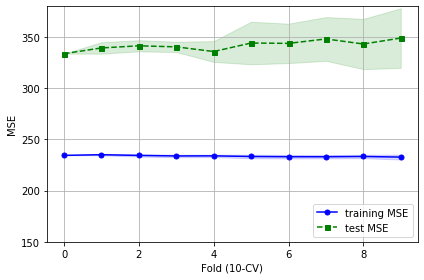

In [20]:
train_mean = means_cv[:,2]
train_std = std_cv[:,2]
test_mean = means_cv[:,0]
test_std = std_cv[:,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=folds,
                markevery=1,
                xlab='Fold (10-CV)',
                ylab='MSE',
                lim=[150, 380],
                file='MSE_holdout10Fold')

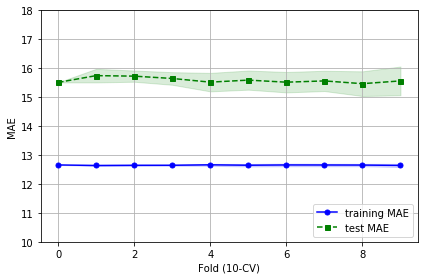

In [21]:
train_mean = means_cv[:,3]
train_std = std_cv[:,3]
test_mean = means_cv[:,1]
test_std = std_cv[:,1]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=folds,
                markevery=1,
                xlab='Fold (10-CV)',
                ylab='MAE',
                lim=[10, 18],
                file='MAE_holdout10Fold')

## Nested 10-fold Cross Validation (N-10-CV)

In [24]:
def nested_k_fold_cv(X, y, n_neighbors, folds, n, log=True, seed=12345):

    rng = np.random.RandomState(seed=seed)
    seeds = np.arange(10**5); rng.shuffle(seeds); seeds=seeds[:n]

    metrics, means, std = [np.empty((n,4)) for _ in range(3)]

    for index in range(n):

        metrics_cv, *_ = k_fold_cv(X, y, n_neighbors, folds, seed=seeds[index], log=False)

        metrics[index,:] = np.mean(metrics_cv, axis=0)
        means[index,:] = np.mean(metrics[:(index+1)], axis=0)
        std[index,:] = np.std(metrics[:(index+1)], axis=0)

        if ((index+1) % (int(n/10)) == 0) & log:
            print(f"{index+1} / {n} test MSE: {metrics[index,:][0]:.4f} std: {std[index,:][0]:.4f} | train MSE: {metrics[index,:][2]:.4f} std: {std[index,:][2]:.4f}")

    if log:
        print("Done!")
        
    return metrics, means, std

In [25]:
n = 50
folds = 10

metrics_ncv, means_ncv, std_ncv = nested_k_fold_cv(X, y, n_neighbors, folds, n)

5 / 50 test MSE: 355.0425 std: 3.2412 | train MSE: 232.6091 std: 0.5724
10 / 50 test MSE: 349.0768 std: 3.7088 | train MSE: 234.3002 std: 0.5986
15 / 50 test MSE: 352.0713 std: 3.4905 | train MSE: 233.8118 std: 0.5324
20 / 50 test MSE: 350.7849 std: 3.1969 | train MSE: 234.0268 std: 0.5514
25 / 50 test MSE: 350.3358 std: 2.9295 | train MSE: 232.9113 std: 0.5916
30 / 50 test MSE: 352.1791 std: 3.2342 | train MSE: 234.1941 std: 0.5851
35 / 50 test MSE: 350.0629 std: 3.0778 | train MSE: 234.2456 std: 0.5582
40 / 50 test MSE: 346.0720 std: 3.0500 | train MSE: 234.0835 std: 0.5413
45 / 50 test MSE: 347.9022 std: 3.0950 | train MSE: 234.8433 std: 0.5577
50 / 50 test MSE: 343.9117 std: 3.2539 | train MSE: 233.9725 std: 0.5686
Done!


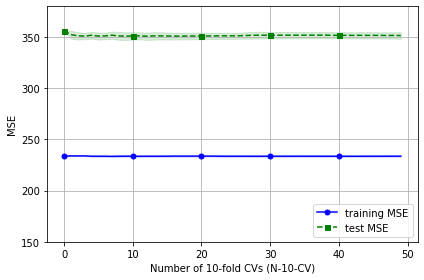

In [26]:
train_mean = means_ncv[:,2]
train_std = std_ncv[:,2]
test_mean = means_ncv[:,0]
test_std = std_ncv[:,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=n,
                markevery=10,
                xlab='Number of 10-fold CVs (N-10-CV)',
                ylab='MSE',
                lim=[150, 380],
                file='MSE_N-10-CV')

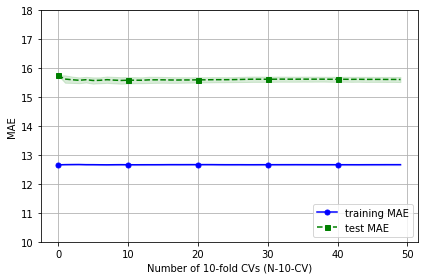

In [27]:
train_mean = means_ncv[:,3]
train_std = std_ncv[:,3]
test_mean = means_ncv[:,1]
test_std = std_ncv[:,1]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=n,
                markevery=10,
                xlab='Number of 10-fold CVs (N-10-CV)',
                ylab='MAE',
                lim=[10, 18],
                file='MAE_N-10-CV')

## Bootstrapping

In [51]:
def bootstrap(X, y, bootstraps, n_neighbors, test_size, seed=12345, log=True):
    
    rng = np.random.RandomState(seed=seed)

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=test_size,
                                                   random_state=seed)
    
    metrics, means, std = [np.empty((bootstraps,4)) for _ in range(3)]
    
    sample_size = X_train.shape[0]
    
    for index in range(bootstraps):
        
        bootstrap = np.random.choice(np.arange(sample_size), sample_size, replace=True)
        X_bootstrap = X_train[bootstrap]
        y_bootstrap = y_train[bootstrap]
        
        V = np.cov(X_bootstrap.T)

        KNN_regressor = KNeighborsRegressor(n_neighbors=n_neighbors,
                                             weights='uniform',
                                             algorithm='auto',
                                             metric='mahalanobis',
                                             metric_params={'V':V})

        KNN_regressor.fit(X_bootstrap, y_bootstrap)
        pred_test = KNN_regressor.predict(X_test)
        pred_train = KNN_regressor.predict(X_bootstrap)
        metrics[index,:] = MSE(y_test, pred_test), MAE(y_test, pred_test), MSE(y_bootstrap, pred_train), MAE(y_bootstrap, pred_train)
        means[index,:] = np.mean(metrics[:(index+1)], axis=0)
        std[index,:] = np.std(metrics[:(index+1)], axis=0)
        
        if ((index+1) % (int(bootstraps/10)) == 0) & log:
            print(f"{index+1} / {bootstraps} test MSE: {metrics[index,:][0]:.4f} std: {std[index,:][0]:.4f} | train MSE: {metrics[index,:][2]:.4f} std: {std[index,:][2]:.4f}")

    if log:
        print("Done!")
        
    return metrics, means, std

In [31]:
bootstraps=100

metrics_bt, means_bt, std_bt = bootstrap(X, y, bootstraps, n_neighbors=n_neighbors, seed=1, test_size=test_size)

10 / 100 test MSE: 384.7778 std: 14.7781 | train MSE: 185.3238 std: 5.3455
20 / 100 test MSE: 412.8283 std: 18.5174 | train MSE: 179.0708 std: 6.8588
30 / 100 test MSE: 377.7710 std: 16.8659 | train MSE: 177.5455 std: 6.9913
40 / 100 test MSE: 377.8653 std: 16.3323 | train MSE: 185.3221 std: 6.6029
50 / 100 test MSE: 357.9461 std: 19.5534 | train MSE: 172.6071 std: 6.5762
60 / 100 test MSE: 411.4916 std: 18.7154 | train MSE: 176.0599 std: 7.3774
70 / 100 test MSE: 372.0875 std: 19.7512 | train MSE: 183.2926 std: 7.3267
80 / 100 test MSE: 416.9630 std: 20.2306 | train MSE: 184.8870 std: 7.1485
90 / 100 test MSE: 394.0202 std: 20.8136 | train MSE: 177.0911 std: 6.9658
100 / 100 test MSE: 400.3771 std: 20.5983 | train MSE: 178.9030 std: 6.9311
Done!


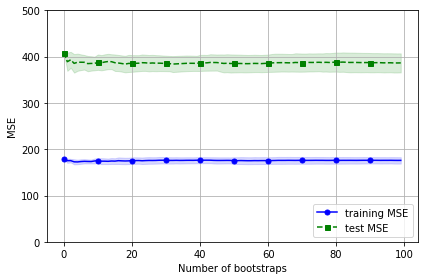

In [143]:
train_mean = means_bt[:,2]
train_std = std_bt[:,2]
test_mean = means_bt[:,0]
test_std = std_bt[:,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=bootstraps,
                markevery=10,
                xlab='Number of bootstraps',
                ylab='MSE',
                lim=[0, 500],
                file='MSE_bootstraps100')

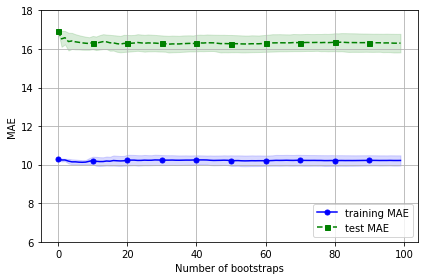

In [34]:
train_mean = means_bt[:,3]
train_std = std_bt[:,3]
test_mean = means_bt[:,1]
test_std = std_bt[:,1]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=bootstraps,
                markevery=10,
                xlab='Number of bootstraps',
                ylab='MAE',
                lim=[6, 18],
                file='MAE_bootstraps100')

# Question 3 - varying K

In [22]:
max_k = 20
parameters = range(1,max_k+1)

## Holdout

In [23]:
metrics_hld = np.empty((max_k,4))

rng = np.random.RandomState(seed=12345)
seeds = np.arange(10**5); rng.shuffle(seeds); seeds=seeds[:max_k+1]

for parameter in parameters:

    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       test_size=test_size,
                                                       random_state=seeds[parameter])
    V = np.cov(X_train.T)

    KNN_regressor = KNeighborsRegressor(n_neighbors=parameter,
                                         weights='uniform',
                                         algorithm='auto',
                                         metric='mahalanobis',
                                         metric_params={'V':V})

    KNN_regressor.fit(X_train, y_train)
    pred_train = KNN_regressor.predict(X_train)
    pred_test = KNN_regressor.predict(X_test)
    
    metrics_hld[parameter-1,] = MSE(y_test, pred_test), MAE(y_test, pred_test), MSE(y_train, pred_train), MAE(y_train, pred_train)

## Repeated holdout

In [67]:
def iterate_over_param(X, y, max_k, evaluation_model, model_param, parameter_key, seeds_required=True, seed=12345):
    
    means_param, std_param = [np.empty((max_k,4)) for _ in range(2)]

    rng = np.random.RandomState(seed=seed)
    seeds = np.arange(10**5); rng.shuffle(seeds); seeds=seeds[:max_k+1]
    
    parameters = range(1,max_k+1)
    
    for parameter in parameters:
        
        if seeds_required:
            model_param['seed'] = seeds[parameter]
            
        model_param[parameter_key] = parameter
        
        metrics, means, std = evaluation_model(X, y, **model_param)

        means_param[parameter-1,:] = np.mean(metrics, axis=0)    
        std_param[parameter-1,:] = np.std(metrics, axis=0)

        print(f"K: {parameter} test MSE: {means_param[parameter-1,:][0]:.4f} std: {std_param[parameter-1,:][0]:.4f} | train MSE {means_param[parameter-1,:][2]:.4f} std: {std_param[parameter-1,:][2]:.4f}  ")

    print("Done")
    return means_param, std_param

In [68]:
n = 100

means_rph, std_rph = iterate_over_param(X, y, max_k, repeated_holdout, {'n':n, 'test_size':test_size, 'log':False}, parameter_key='n_neighbors')

K: 1 test MSE: 589.8867 std: 39.6774 | train MSE 0.0000 std: 0.0000  
K: 2 test MSE: 436.5609 std: 33.3337 | train MSE 147.0484 std: 4.6982  
K: 3 test MSE: 391.3697 std: 23.2022 | train MSE 194.8638 std: 5.1343  
K: 4 test MSE: 368.4727 std: 24.6736 | train MSE 218.7596 std: 5.5339  
K: 5 test MSE: 351.4719 std: 21.5159 | train MSE 233.9926 std: 5.3611  
K: 6 test MSE: 338.7185 std: 19.4866 | train MSE 245.3678 std: 5.0929  
K: 7 test MSE: 333.1704 std: 18.6027 | train MSE 251.4303 std: 4.8013  
K: 8 test MSE: 328.1909 std: 19.5116 | train MSE 255.4400 std: 4.5051  
K: 9 test MSE: 321.5185 std: 18.8735 | train MSE 259.7628 std: 5.2588  
K: 10 test MSE: 319.6372 std: 16.4494 | train MSE 261.8980 std: 4.4692  
K: 11 test MSE: 315.9609 std: 14.9359 | train MSE 264.6539 std: 4.2197  
K: 12 test MSE: 312.6581 std: 20.2725 | train MSE 266.1061 std: 5.8329  
K: 13 test MSE: 308.9278 std: 17.7489 | train MSE 267.8839 std: 5.2129  
K: 14 test MSE: 310.3434 std: 18.1785 | train MSE 268.1025 std

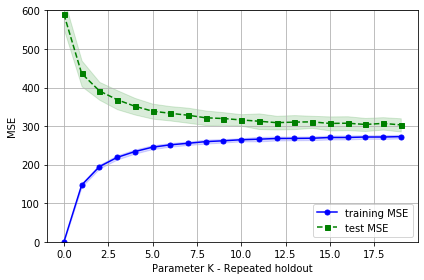

In [69]:
train_mean = means_rph[:,2]
train_std = std_rph[:,2]
test_mean = means_rph[:,0]
test_std = std_rph[:,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=max_k,
                markevery=1,
                xlab='Parameter K - Repeated holdout',
                ylab='MSE',
                lim=[0, 600],
                file='MSE_RepeatedHoldoutKOptimize')

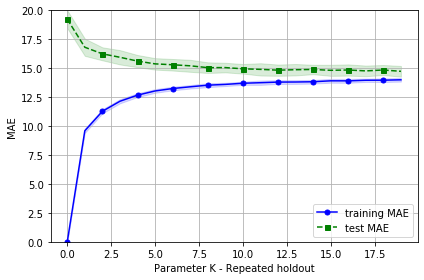

In [81]:
train_mean = means_rph[:,3]
train_std = std_rph[:,3]
test_mean = means_rph[:,1]
test_std = std_rph[:,1]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=max_k,
                markevery=2,
                xlab='Parameter K - Repeated holdout',
                ylab='MAE',
                lim=[0, 20],
                file='MAE_RepeatedHoldoutKOptimize')

## Leave-One-Out Cross-Validation (LOOCV)

In [38]:
#Let op, dit ding is pas klaar tegen de tijd dat je 80 bent
means_loocv_po, std_loocv_po = iterate_over_param(X, y, max_k, loocv, {'log':False}, parameter_key='n_neighbors')

K: 1 test MSE: 582.5239 std: 748.1722 | train MSE 0.0000 std: 0.0000  
K: 2 test MSE: 443.0283 std: 568.7768 | train MSE 145.7477 std: 0.2892  
K: 3 test MSE: 388.5664 std: 474.9134 | train MSE 197.3279 std: 0.4153  
K: 4 test MSE: 364.8409 std: 431.2678 | train MSE 218.7633 std: 0.5172  
K: 5 test MSE: 349.0405 std: 402.8348 | train MSE 233.6128 std: 0.4128  
K: 6 test MSE: 343.8874 std: 395.4071 | train MSE 242.6467 std: 0.3761  
K: 7 test MSE: 334.7067 std: 384.9329 | train MSE 253.1216 std: 0.3865  
K: 8 test MSE: 327.3223 std: 372.0058 | train MSE 256.6894 std: 0.3801  
K: 9 test MSE: 320.6231 std: 362.0866 | train MSE 259.8104 std: 0.3536  
K: 10 test MSE: 320.0688 std: 359.4104 | train MSE 260.0634 std: 0.3677  
K: 11 test MSE: 318.1955 std: 358.8949 | train MSE 263.7839 std: 0.3439  
K: 12 test MSE: 317.1382 std: 356.9212 | train MSE 268.0253 std: 0.3564  
K: 13 test MSE: 313.0701 std: 349.8855 | train MSE 270.6852 std: 0.3702  
K: 14 test MSE: 309.5752 std: 345.6595 | train MS

In [ ]:
train_mean = means_loocv_po[:,2]
train_std = std_loocv_po[:,2]
test_mean = means_loocv_po[:,0]
test_std = std_loocv_po[:,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=max_k,
                markevery=1,
                xlab='Parameter K - LOOCV',
                ylab='MSE',
                lim=[150, 380],
                file='MSE_LOOCVKOptimize',
                std=False)

In [ ]:
train_mean = means_loocv_po[:,3]
train_std = std_loocv_po[:,3]
test_mean = means_loocv_po[:,1]
test_std = std_loocv_po[:,1]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=max_k,
                markevery=2,
                xlab='Parameter K -LOOCV',
                ylab='MAE',
                lim=[0, 20],
                file='MAE_LOOCVKOptimize',
                std=False)

## 10-fold Cross-Validation (CV)

In [71]:
folds = 10

means_10cv_po, std_10cv_po = iterate_over_param(X, y, max_k, k_fold_cv, {'folds':folds, 'log':False}, parameter_key='n_neighbors')

K: 1 test MSE: 571.1905 std: 48.2308 | train MSE 0.0000 std: 0.0000  
K: 2 test MSE: 445.9161 std: 35.3493 | train MSE 146.3110 std: 2.8454  
K: 3 test MSE: 389.8379 std: 32.1153 | train MSE 196.4947 std: 4.4452  
K: 4 test MSE: 371.9971 std: 38.4374 | train MSE 218.1978 std: 3.4077  
K: 5 test MSE: 346.9770 std: 29.9678 | train MSE 233.3586 std: 4.0619  
K: 6 test MSE: 342.1246 std: 34.0909 | train MSE 244.1285 std: 3.6210  
K: 7 test MSE: 337.2262 std: 43.5189 | train MSE 251.4821 std: 4.5765  
K: 8 test MSE: 324.9382 std: 16.8347 | train MSE 256.0207 std: 2.2092  
K: 9 test MSE: 321.1391 std: 32.8618 | train MSE 259.1189 std: 4.0215  
K: 10 test MSE: 323.5690 std: 25.3226 | train MSE 261.8165 std: 2.3706  
K: 11 test MSE: 319.4833 std: 31.6956 | train MSE 265.0826 std: 3.9311  
K: 12 test MSE: 314.4074 std: 30.7413 | train MSE 266.5610 std: 4.3910  
K: 13 test MSE: 312.9323 std: 19.7058 | train MSE 268.2459 std: 3.2658  
K: 14 test MSE: 309.3248 std: 23.0097 | train MSE 268.9822 std

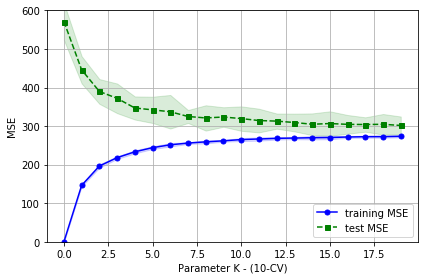

In [80]:
train_mean = means_10cv_po[:,2]
train_std = std_10cv_po[:,2]
test_mean = means_10cv_po[:,0]
test_std = std_10cv_po[:,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=max_k,
                markevery=1,
                xlab='Parameter K - (10-CV)',
                ylab='MSE',
                lim=[0, 600],
                file='MSE_10CVKOptimize')

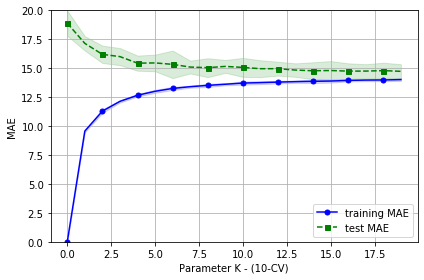

In [73]:
train_mean = means_10cv_po[:,3]
train_std = std_10cv_po[:,3]
test_mean = means_10cv_po[:,1]
test_std = std_10cv_po[:,1]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=max_k,
                markevery=2,
                xlab='Parameter K - (10-CV)',
                ylab='MAE',
                lim=[0, 20],
                file='MAE_10CVKOptimize')

## Nested 10-fold Cross Validation (N-10-CV)

In [ ]:
folds = 10
n = 50

means_n10cv_po, std_n10cv_po = iterate_over_param(X, y, max_k, nested_k_fold_cv, {'folds':folds, 'log':False, 'n':n}, parameter_key='n_neighbors')

K: 1 test MSE: 582.2137 std: 8.9164 | train MSE 0.0000 std: 0.0000  
K: 2 test MSE: 440.4750 std: 6.0598 | train MSE 146.4388 std: 0.3520  
K: 3 test MSE: 389.3825 std: 4.6085 | train MSE 196.0401 std: 0.5851  
K: 4 test MSE: 365.9229 std: 4.0198 | train MSE 219.2758 std: 0.4384  
K: 5 test MSE: 350.1589 std: 3.4860 | train MSE 233.6098 std: 0.4451  
K: 6 test MSE: 341.4170 std: 2.7376 | train MSE 244.1132 std: 0.5045  
K: 7 test MSE: 334.0701 std: 2.5590 | train MSE 251.7987 std: 0.4639  
K: 8 test MSE: 327.2632 std: 2.5801 | train MSE 255.7547 std: 0.4200  
K: 9 test MSE: 322.6320 std: 2.6188 | train MSE 258.9929 std: 0.3787  
K: 10 test MSE: 320.3858 std: 2.3470 | train MSE 261.8078 std: 0.3271  
K: 11 test MSE: 317.9918 std: 2.1765 | train MSE 264.7149 std: 0.4091  
K: 12 test MSE: 314.3987 std: 2.5388 | train MSE 266.8235 std: 0.3366  
K: 13 test MSE: 311.5021 std: 1.9367 | train MSE 268.1440 std: 0.3379  
K: 14 test MSE: 309.1281 std: 2.2864 | train MSE 268.6703 std: 0.2656  
K: 

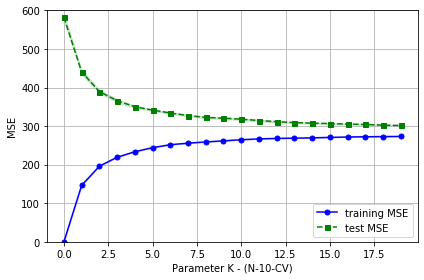

In [7]:
train_mean = means_n10cv_po[:,2]
train_std = std_n10cv_po[:,2]
test_mean = means_n10cv_po[:,0]
test_std = std_n10cv_po[:,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=max_k,
                markevery=1,
                xlab='Parameter K - (N-10-CV)',
                ylab='MSE',
                lim=[0, 600],
                file='MSE_N10CVKOptimize')

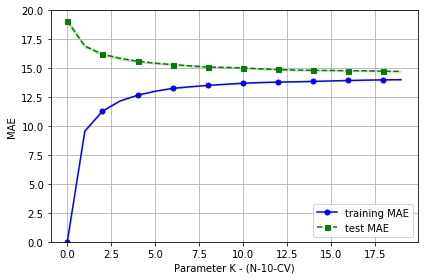

In [8]:
train_mean = means_n10cv_po[:,3]
train_std = std_n10cv_po[:,3]
test_mean = means_n10cv_po[:,1]
test_std = std_n10cv_po[:,1]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=max_k,
                markevery=2,
                xlab='Parameter K - (N-10-CV)',
                ylab='MAE',
                lim=[0, 20],
                file='MAE_N10CVKOptimize')

## Bootstrapping

In [77]:
bootstraps = 100

means_bt_po, std_bt_po = iterate_over_param(X,
                                            y,
                                            max_k, bootstrap,
                                            {'bootstraps':bootstraps, 'test_size':test_size, 'log':False},
                                            parameter_key='n_neighbors',
                                            seeds_required=False)

K: 1 test MSE: 611.1443 std: 29.9000 | train MSE 0.0000 std: 0.0000  
K: 2 test MSE: 524.6228 std: 28.8484 | train MSE 53.3512 std: 3.9677  
K: 3 test MSE: 467.2955 std: 22.5694 | train MSE 104.1217 std: 5.7555  
K: 4 test MSE: 431.7866 std: 19.8023 | train MSE 142.3785 std: 7.1757  
K: 5 test MSE: 408.6459 std: 16.8738 | train MSE 170.9169 std: 6.5186  
K: 6 test MSE: 390.8214 std: 16.1356 | train MSE 191.2731 std: 8.9465  
K: 7 test MSE: 378.5712 std: 15.9205 | train MSE 205.8030 std: 8.9614  
K: 8 test MSE: 366.4157 std: 14.5744 | train MSE 215.5136 std: 7.8168  
K: 9 test MSE: 355.6432 std: 13.6275 | train MSE 225.2856 std: 9.4096  
K: 10 test MSE: 348.4401 std: 12.0371 | train MSE 230.8056 std: 10.0156  
K: 11 test MSE: 337.7030 std: 11.4399 | train MSE 236.8911 std: 10.1917  
K: 12 test MSE: 332.2981 std: 10.5246 | train MSE 241.0690 std: 10.4308  
K: 13 test MSE: 328.5549 std: 11.8696 | train MSE 247.3623 std: 10.2362  
K: 14 test MSE: 324.2676 std: 11.2580 | train MSE 250.8508 

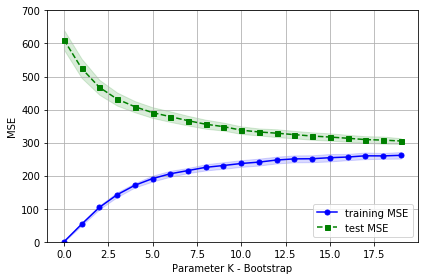

In [78]:
train_mean = means_bt_po[:,2]
train_std = std_bt_po[:,2]
test_mean = means_bt_po[:,0]
test_std = std_bt_po[:,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=max_k,
                markevery=1,
                xlab='Parameter K - Bootstrap',
                ylab='MSE',
                lim=[0, 700],
                file='MSE_Bootstrap100Optimize')

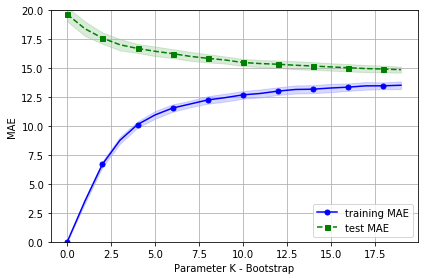

In [79]:
train_mean = means_bt_po[:,3]
train_std = std_bt_po[:,3]
test_mean = means_bt_po[:,1]
test_std = std_bt_po[:,1]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=max_k,
                markevery=2,
                xlab='Parameter K - Bootstrap',
                ylab='MAE',
                lim=[0, 20],
                file='MAE_Bootstrap100Optimize')

In [89]:
#Learning curve

sample_size = X.shape[0]
number_of_obs = sample_size-50

means_lc, std_lc = [np.empty((number_of_obs,4)) for _ in range(2)]

for index, size in enumerate(range(50,number_of_obs)):
    
    sample_index = np.random.choice(np.arange(sample_size), size, replace=False)
    
    X_lc = X[sample_index]
    y_lc = y[sample_index]

    metrics_cvl, means_cvl, std_cvl = k_fold_cv(X_lc, y_lc, 20, 10, log=False)
    
    means_lc[index,:] = np.mean(metrics_cvl, axis=0)
    std_lc[index,:] = np.std(metrics_cvl, axis=0)
    if ((index+1) % (int(number_of_obs/10)) == 0):
            print(f"{index+1} / {number_of_obs}")

print("Done!")

143 / 1433
286 / 1433
429 / 1433
572 / 1433
715 / 1433
858 / 1433
1001 / 1433
1144 / 1433
1287 / 1433
Done!


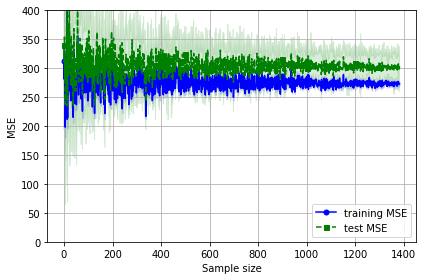

In [97]:
train_mean = means_lc[:number_of_obs-50,2]
train_std = std_lc[:number_of_obs-50,2]
test_mean = means_lc[:number_of_obs-50,0]
test_std = std_lc[:number_of_obs-50,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=number_of_obs-50,
                markevery=100,
                xlab='Sample size',
                ylab='MSE',
                lim=[0, 400],
                file='MSE_LC2')

In [134]:
#Creating a rolling average, as the original is quite noisy
mean_lc_r, std_lc_r = [np.empty((means_lc.shape[0]-100,4)) for _ in range(2)]

for i in range(means_lc.shape[0]-100):
    mean_lc_r[i,:] = np.mean(means_lc[i:(i+50)],axis=0)
    std_lc_r[i,:] = np.std(means_lc[i:(i+50)],axis=0)

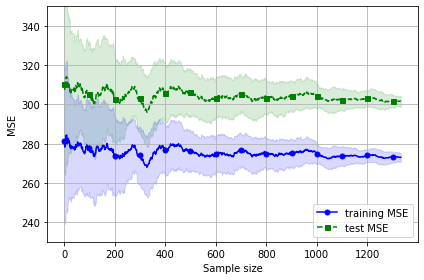

In [128]:
train_mean = mean_lc_r[:,2]
train_std = std_lc_r[:,2]
test_mean = mean_lc_r[:,0]
test_std = std_lc_r[:,0]

plot_train_test(train_mean,
                train_std,
                test_mean,
                test_std,
                length=mean_lc_r.shape[0],
                markevery=100,
                xlab='Sample size',
                ylab='MSE',
                lim=[230, 350],
                file='MSE_LCR3')

In [135]:
#This is quite a hacky solution to shift the x-axes of the graph 100 to the left.
mean_lc_r_hack = np.zeros((mean_lc_r.shape[0]+100,4))
std_lc_r_hack = np.zeros((mean_lc_r.shape[0]+100,4))

mean_lc_r_hack[100:] = mean_lc_r
std_lc_r_hack[100:] = std_lc_r

In [136]:
def plot_train_test_hack(train_mean, train_std, test_mean, test_std, length, markevery, xlab, ylab, lim, xlim, file, std=True):

    number_of_repetitions = np.arange(length)

    plt.plot(number_of_repetitions, train_mean,
             color='blue', marker='o',
             markersize=5, label=f'training {ylab}', markevery=markevery)

    plt.plot(number_of_repetitions, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label=f'test {ylab}', markevery=markevery)

    if std:
        plt.fill_between(number_of_repetitions,
                         test_mean + test_std,
                         test_mean - test_std,
                         alpha=0.15, color='green')

        plt.fill_between(number_of_repetitions,
                         train_mean + train_std,
                         train_mean - train_std,
                         alpha=0.15, color='blue')

    plt.grid()
    plt.xlabel(f'{xlab}')
    plt.ylabel(f'{ylab}')
    plt.legend(loc='lower right')
    plt.ylim(lim)
    plt.xlim(xlim)
    plt.tight_layout()
    plt.savefig(f'images/{file}.svg', dpi=300)
    plt.show()

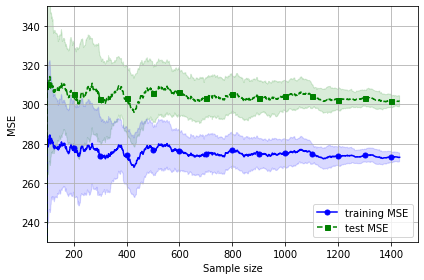

In [142]:
train_mean = mean_lc_r_hack[:,2]
train_std = std_lc_r_hack[:,2]
test_mean = mean_lc_r_hack[:,0]
test_std = std_lc_r_hack[:,0]

plot_train_test_hack(train_mean,
                train_std,
                test_mean,
                test_std,
                length=mean_lc_r_hack.shape[0],
                markevery=100,
                xlab='Sample size',
                ylab='MSE',
                lim=[230, 350],
                xlim=[100,1500],
                file='MSE_LCR4')

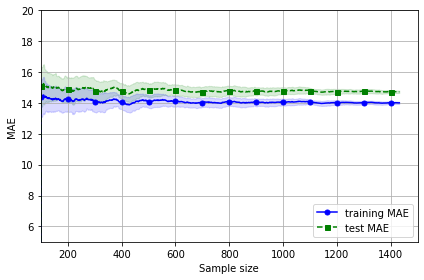

In [146]:
train_mean = mean_lc_r_hack[:,3]
train_std = std_lc_r_hack[:,3]
test_mean = mean_lc_r_hack[:,1]
test_std = std_lc_r_hack[:,1]

plot_train_test_hack(train_mean,
                train_std,
                test_mean,
                test_std,
                length=mean_lc_r_hack.shape[0],
                markevery=100,
                xlab='Sample size',
                ylab='MAE',
                lim=[5, 20],
                xlim=[100,1500],
                file='MAE_LCR4')